### Knapsack Problem using Variational Quantum Eigensolver with Qiskit

This tutorial will walk you through solving the Knapsack problem, a classic optimization challenge, using a quantum algorithm called the Variational Quantum Eigensolver (VQE). We will use Qiskit to define the problem, convert it into a format suitable for a quantum computer, and then use VQE to find an approximate solution.

First, let's ensure Qiskit is installed and check the version.

In [109]:
import qiskit
print(qiskit.__version__)

1.3.1


### The Knapsack Problem

The Knapsack problem involves selecting a set of items, each with a specific weight and value, to maximize the total value without exceeding a given maximum weight capacity. It's a binary optimization problem: for each item, you either include it in the knapsack or you don't.

### Setting Up the Environment

Before we define the problem, we need to import the necessary libraries. These include:

- **Basic libraries:** numpy for numerical operations and matplotlib for plotting.

- **Qiskit Optimization:** Tools to define the Knapsack problem (Knapsack), convert it into a quadratic program, and map it to a quantum problem (QuadraticProgramToQubo).

- **Qiskit Algorithms:** The core VQE components, including the Estimator primitive for calculating expectation values and the EfficientSU2 ansatz.

- **SciPy:** A classical optimizer that VQE will use to minimize the cost function.

- **Qiskit Aer:** To simulate a quantum backend for our experiment.

In [110]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# quantum imports
from qiskit_optimization.applications import Maxcut, Knapsack
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method="automatic")


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

### **Generate a Random Instance**

To make things interesting, let's create a random instance of the Knapsack problem. We'll define the number of items and generate random weights and values for each. The knapsack's capacity is set to 60% of the total weight of all items.

We then create a `Knapsack` object and convert it to a `QuadraticProgram`, which is a standard format for optimization problems.

In [111]:
# Set the random seed for reproducibility
np.random.seed(135)

# Parameters for the knapsack problem
num_items = 4
max_weight = 8

# Generate random weights and values for the items

weights = np.random.randint(1, 10, size=num_items)
values = np.random.randint(10, 50, size=num_items)

# Capacity of the knapsack
capacity = int(0.6 * np.sum(weights))

print(f"Weights: {weights}")
print(f"Values: {values}")
print(f"Capacity: {capacity}")

# Create the Knapsack problem
knapsack = Knapsack(values.tolist(), weights.tolist(), capacity)

# Convert the problem to a QuadraticProgram
problem = knapsack.to_quadratic_program()
print(problem.prettyprint())



Weights: [6 9 7 8]
Values: [29 41 41 39]
Capacity: 18
Problem name: Knapsack

Maximize
  29*x_0 + 41*x_1 + 41*x_2 + 39*x_3

Subject to
  Linear constraints (1)
    6*x_0 + 9*x_1 + 7*x_2 + 8*x_3 <= 18  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [112]:
num_binary_vars_classical = problem.get_num_binary_vars()
print(f"Number of binary variables: {num_binary_vars_classical}")

Number of binary variables: 4


### **Finding the Exact Solution Classically**

Before turning to a quantum approach, let's find the exact solution using a classical optimizer. This will serve as our benchmark to see how well the VQE performs. We use the `CplexOptimizer` from Qiskit Optimization for this purpose. The solution `x` is a binary vector where `1` means an item is selected and `0` means it's left out.

In [113]:
# Solve the problem using CplexOptimizer
optimizer = CplexOptimizer()
result = optimizer.solve(problem)

result_classical = result
print(f"Optimal value: {result_classical.fval}, Solution vector: {result_classical.x}")


Optimal value: 82.0, Solution vector: [0. 1. 1. 0.]


### **From Quadratic Program to QUBO**

Quantum computers solve problems formulated as Hamiltonians. A common step is to first convert the problem into a **Quadratic Unconstrained Binary Optimization (QUBO)** problem. This format represents the problem as a single quadratic equation to be minimized, without any constraints.

The conversion automatically creates "slack" variables to transform the inequality constraint (total weight <= capacity) into an equality, which is then incorporated into the objective function with a penalty.

In [114]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Minimize
 obj: - 32645 x_0 - 48965 x_1 - 38093 x_2 - 43527 x_3 - 5436 c0@int_slack@0
      - 10872 c0@int_slack@1 - 21744 c0@int_slack@2 - 43488 c0@int_slack@3
      - 16308 c0@int_slack@4 + [ 10872 x_0^2 + 32616 x_0*x_1 + 25368 x_0*x_2
      + 28992 x_0*x_3 + 3624 x_0*c0@int_slack@0 + 7248 x_0*c0@int_slack@1
      + 14496 x_0*c0@int_slack@2 + 28992 x_0*c0@int_slack@3
      + 10872 x_0*c0@int_slack@4 + 24462 x_1^2 + 38052 x_1*x_2 + 43488 x_1*x_3
      + 5436 x_1*c0@int_slack@0 + 10872 x_1*c0@int_slack@1
      + 21744 x_1*c0@int_slack@2 + 43488 x_1*c0@int_slack@3
      + 16308 x_1*c0@int_slack@4 + 14798 x_2^2 + 33824 x_2*x_3
      + 4228 x_2*c0@int_slack@0 + 8456 x_2*c0@int_slack@1
      + 16912 x_2*c0@int_slack@2 + 33824 x_2*c0@int_slack@3
      + 12684 x_2*c0@int_slack@4 + 19328 x_3^2 + 4832 x_3*c0@int_slack@0
      + 9664 x_3*c0@int_slack@1 + 19328 x_3*c0@int_slack@2
      + 38656 x_3*c0@int_slac

As you can see, the QUBO has more variables than the original `num_items` because of the slack variables introduced to handle the weight constraint. Let's check the new number of variables.

In [115]:
num_vars = qubo.get_num_vars()
print(f"Number of variables in QUBO: {num_vars}")
print(f"Number of variables in classical formulation: {num_binary_vars_classical}")
increase = num_vars - num_binary_vars_classical
percent_increase = (increase / num_binary_vars_classical) * 100
print(f"Number of variables increased by {increase} ({percent_increase:.1f}%) when converting to QUBO (due to slack variables for constraints).")

Number of variables in QUBO: 9
Number of variables in classical formulation: 4
Number of variables increased by 5 (125.0%) when converting to QUBO (due to slack variables for constraints).


### **Mapping the QUBO to an Ising Hamiltonian**

The VQE algorithm works by finding the minimum energy (eigenvalue) of a Hamiltonian. We now convert our QUBO problem into an **Ising Hamiltonian**. This Hamiltonian is an operator that can be measured on a quantum computer. Each binary variable in the QUBO is mapped to a qubit.

The conversion gives us two components:

- `qubitOp`: The Ising Hamiltonian, represented as a sum of Pauli operators (Z, ZZ).

- `offset`: A constant energy shift that we'll add back to our final result.

In [116]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 17592.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-5421.5+0.j, -8133.5+0.j, -6321.5+0.j, -7228.5+0.j,  -906. +0.j,
 -1812. +0.j, -3624. +0.j, -7248. +0.j, -2718. +0.j,  4077. +0.j,
  3171. +0.j,  3624. +0.j,   453. +0.j,   906. +0.j,  1812. +0.j,
  3624. +0.j,  1359. +0.j,  4756.5+0.j,  5436. +0.j,   679.5+0.j,
  1359. +0.j,  2718. +0.j,  5436. +0.j,  2038.5+0.j,  4228. +0.j,
   528.5+0.j,

### **The Variational Quantum Eigensolver (VQE)**

VQE is a hybrid quantum-classical algorithm. It uses a quantum computer to prepare a trial wavefunction (using a parameterized circuit called an **ansatz**) and measure the energy of the Hamiltonian. A classical computer then takes this energy and adjusts the parameters of the ansatz to find a new trial state with lower energy. This process is repeated until the minimum energy is found.

#### **The Ansatz**

The ansatz is a parameterized quantum circuit that creates the trial ground state. Its structure is crucial for the success of VQE. A good ansatz should be able to prepare the true ground state of the Hamiltonian. Here, we use `EfficientSU2`, a versatile and commonly used hardware-efficient ansatz from the Qiskit circuit library.


Let's visualize the structure of our ansatz circuit.

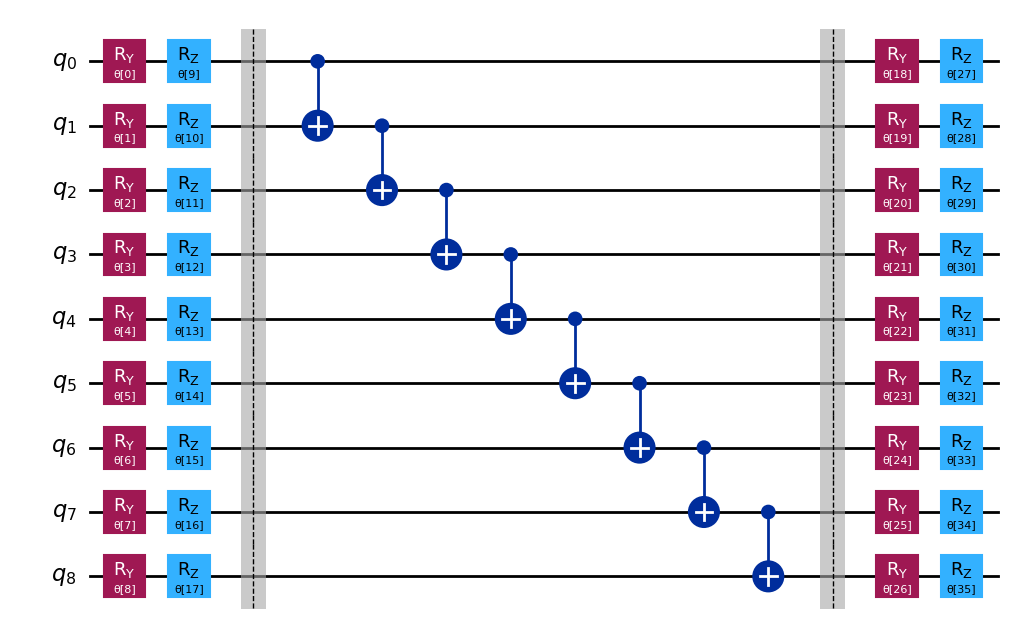

In [117]:
reps = 1 # number of repetitions for the ansatz
ansatz = EfficientSU2(qubitOp.num_qubits, reps=reps, entanglement='linear', insert_barriers=True)  # change the entanglement strategy as needed ('full', 'linear', 'circular', etc.)
ansatz.decompose().draw("mpl", style="iqp")

The classical optimizer needs to tune the parameters of this ansatz. The number of parameters determines the complexity of the classical optimization task.

In [118]:
num_params = ansatz.num_parameters
print(f"The ansatz has {num_params} trainable parameters for {ansatz.num_qubits} qubits (problem variables + slack variables).")

The ansatz has 36 trainable parameters for 9 qubits (problem variables + slack variables).


#### **Executing the VQE Algorithm**

Now we set up and run the VQE algorithm.

- **Cost Function:** We define a `cost_func` that takes the ansatz parameters, builds the circuit, and uses the `Estimator` primitive to calculate the expectation value (energy) of our Hamiltonian. This function returns the energy, which the classical optimizer will try to minimize. We also include a dictionary, `cost_history_dict`, to store the energy at each iteration so we can plot the convergence later.

- **Initial Parameters:** We start the optimization from a random initial set of parameters, `x0`.

- **Classical Optimizer:** We use the `COBYLA` optimizer from `scipy.optimize.minimize` to find the optimal parameters for our ansatz. This optimizer repeatedly calls our `cost_func` to find the parameter values that result in the lowest energy.

In [119]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

This dictionary will store the history of our optimization process.

In [120]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

Let's generate the random starting point for the optimizer

In [121]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.36320536, 1.09364932, 0.20792934, 3.89739215, 6.26591918,
       4.57477237, 0.25817289, 4.82960195, 1.67350939, 1.01244965,
       2.00231871, 5.79211769, 3.65843895, 3.72583764, 0.27447511,
       5.24934293, 4.01878653, 6.17877647, 5.88439093, 0.80665665,
       3.30059598, 5.86688553, 0.2800832 , 2.3447459 , 5.87145192,
       3.5870664 , 5.57835804, 5.10981963, 5.12751702, 3.76013729,
       2.22643022, 2.57887613, 3.67169832, 0.30947226, 0.48096983,
       4.62890779])

Now, we run the classical optimizer. It will print the cost at each iteration, giving us a live view of the VQE's progress as it searches for the minimum energy.

In [122]:
ansatz = ansatz.decompose()

res = minimize(
        cost_func,
        x0,
        args=(ansatz, qubitOp, estimator),
        method="cobyla", # You can change the method to 'nelder-mead', 'bfgs', etc. as needed
        options={"maxiter": 1000, "disp": True, "rhobeg": 0.1, "tol": 1e-6}  # also can adjust the options like 'maxiter', 'disp', 'rhobeg', 'tol' as needed
    )

Iters. done: 1 [Current cost: -6286.1650390625]
Iters. done: 2 [Current cost: -6658.612548828125]
Iters. done: 3 [Current cost: -6154.7021484375]
Iters. done: 4 [Current cost: -7173.668701171875]
Iters. done: 5 [Current cost: -6438.900146484375]
Iters. done: 6 [Current cost: -6104.210693359375]
Iters. done: 7 [Current cost: -6548.07177734375]
Iters. done: 8 [Current cost: -6773.528564453125]
Iters. done: 9 [Current cost: -6519.736083984375]
Iters. done: 10 [Current cost: -6112.545654296875]
Iters. done: 11 [Current cost: -6747.1015625]
Iters. done: 12 [Current cost: -6718.40283203125]
Iters. done: 13 [Current cost: -7117.955810546875]
Iters. done: 14 [Current cost: -6507.268798828125]
Iters. done: 15 [Current cost: -6544.51416015625]
Iters. done: 16 [Current cost: -6358.77880859375]
Iters. done: 17 [Current cost: -6860.392578125]
Iters. done: 18 [Current cost: -6310.44091796875]
Iters. done: 19 [Current cost: -6805.33544921875]
Iters. done: 20 [Current cost: -6695.416748046875]
Iters. 

The optimizer has successfully terminated. The `res` object contains the results, including the final minimized energy (`fun`) and the optimal parameters (`x`).

In [123]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7324.293212890625
       x: [ 2.463e+00  1.033e+00 ...  4.674e-01  4.678e+00]
    nfev: 362
   maxcv: 0.0

### **Post-Processing: Analyzing the Results**

Let's analyze the outcome of our VQE run. First, we can confirm that the final parameters from the optimizer match what we stored in our history dictionary.

In [124]:
all(cost_history_dict["prev_vector"] == res.x)


True

Now, let's plot the cost (energy) against the number of iterations. This convergence plot shows how the VQE algorithm progressively found lower energy states until it converged on a solution.

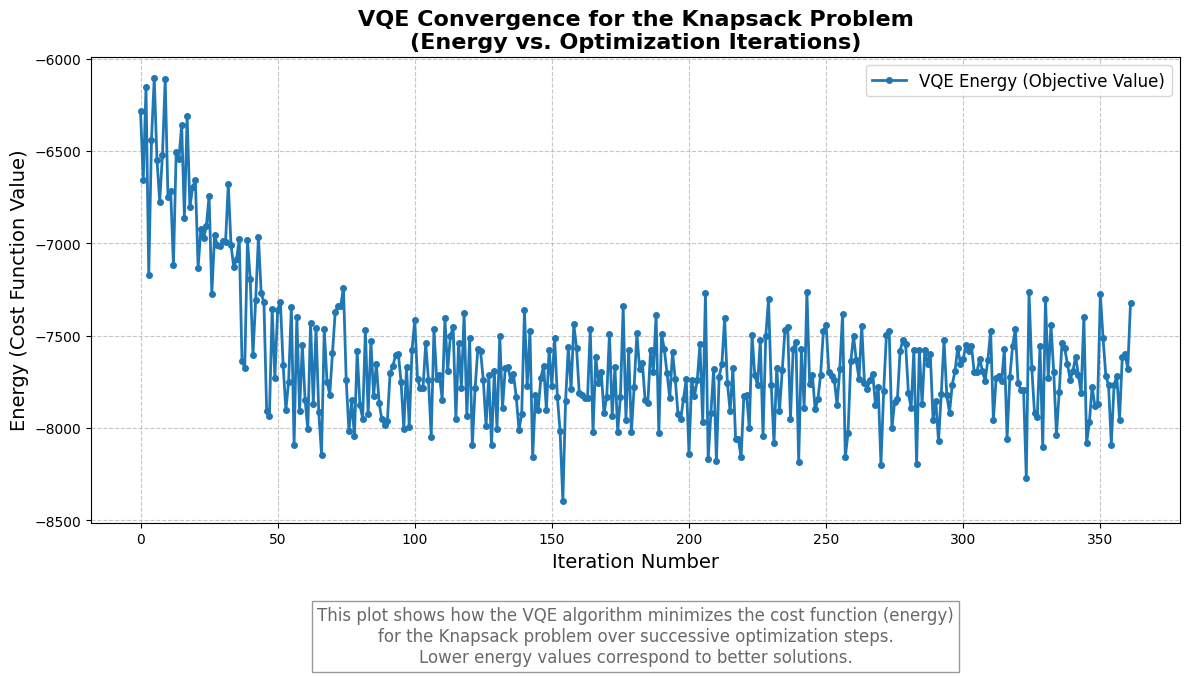

In [125]:
fig, ax = plt.subplots(figsize=(12, 7))  # Bigger figure

ax.plot(
    range(cost_history_dict["iters"]),
    cost_history_dict["cost_history"],
    color="tab:blue",
    linewidth=2,
    marker="o",
    markersize=4,
    label="VQE Energy (Objective Value)"
)

# Add annotations and explanations
ax.set_xlabel("Iteration Number", fontsize=14)
ax.set_ylabel("Energy (Cost Function Value)", fontsize=14)
ax.set_title("VQE Convergence for the Knapsack Problem\n(Energy vs. Optimization Iterations)", fontsize=16, fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(fontsize=12)

# Add a text box explaining the plot
explanation = (
    "This plot shows how the VQE algorithm minimizes the cost function (energy)\n"
    "for the Knapsack problem over successive optimization steps.\n"
    "Lower energy values correspond to better solutions."
)
ax.text(
    0.5, -0.18, explanation,
    fontsize=12, color="dimgray", ha="center", va="top", transform=ax.transAxes,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

plt.tight_layout()
plt.show()

### Run the Optimized Circuit and Sample the Solution

The VQE optimization has given us the best parameters for our ansatz. We now plug these parameters into the circuit to prepare the approximate ground state of our Hamiltonian.

Since the goal is to find the solution bitstring, we add measurements to all qubits and use the `Sampler` primitive to run the circuit many times (e.g., 10,000 "shots") and collect the measurement outcomes.

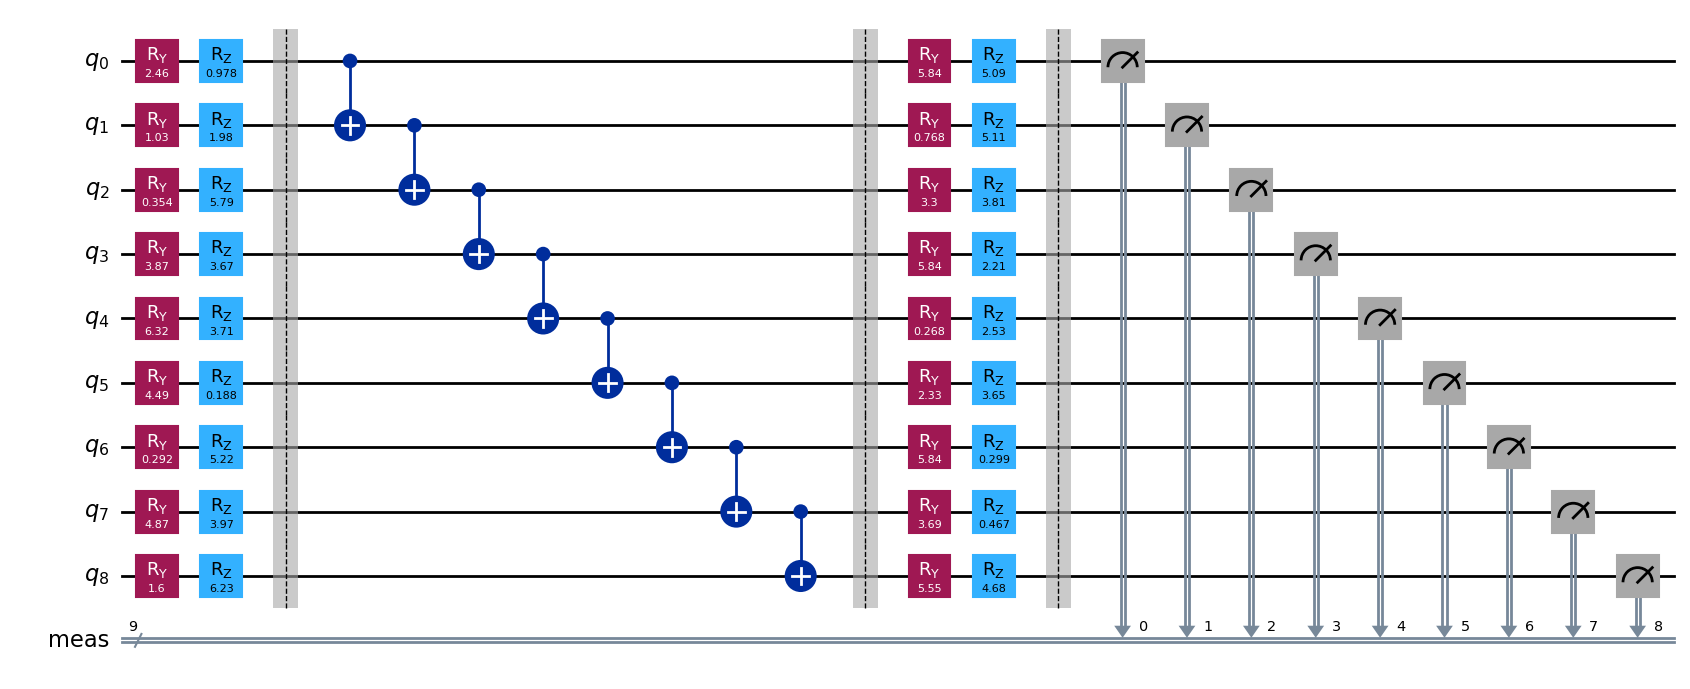

In [126]:
ansatz = ansatz.assign_parameters(res.x)
ansatz.measure_all()
ansatz.draw("mpl", style="iqp")

In [127]:
pub = (ansatz,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

The output of the sampler is a probability distribution over all possible measurement outcomes (bitstrings). The bitstring with the highest probability is our candidate for the optimal solution.

In [128]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_vars)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 0, 0, 0, 1, 0, 0]


In [129]:
result = converter.interpret(most_likely_bitstring)
cost = problem.objective.evaluate(result)
feasible =problem.get_feasibility_info(result)[0]


print("Result knapsack:", result)
print("Result value:", cost)
print("Feasible:", feasible)

Result knapsack: [1. 1. 0. 0.]
Result value: 70.0
Feasible: True


In [130]:
print("="*40)
print("🔎 Best Known Classical Solution")
print("="*40)
print(f"  • Total Value:        {result_classical.fval}")
print(f"  • Solution Vector:    {result_classical.x}")
print()

print("="*40)
print("⚛️  VQE (Quantum) Solution")
print("="*40)
print(f"  • Total Value:        {cost}")
print(f"  • Solution Vector:    {result}")
print(f"  • Feasible:           {feasible}")

if feasible:
    optimality_gap = 100 * (result_classical.fval - cost) / result_classical.fval
    print(f"  • Optimality Gap:     {optimality_gap:.2f}%")
else:
    print("  • Note: Quantum solution is not feasible.")

print("\n" + "-"*40)
if feasible:
    if abs(cost - result_classical.fval) < 1e-6:
        print("✅ Quantum solution matches the classical optimum!")
    else:
        print("ℹ️  Quantum solution is suboptimal compared to classical.")
else:
    print("❌ Quantum solution is not feasible.")
print("-"*40)

🔎 Best Known Classical Solution
  • Total Value:        82.0
  • Solution Vector:    [0. 1. 1. 0.]

⚛️  VQE (Quantum) Solution
  • Total Value:        70.0
  • Solution Vector:    [1. 1. 0. 0.]
  • Feasible:           True
  • Optimality Gap:     14.63%

----------------------------------------
ℹ️  Quantum solution is suboptimal compared to classical.
----------------------------------------


Because VQE is a heuristic and quantum measurements are probabilistic, the highest probability state might not always be the correct one. It's often useful to examine the top few most likely outcomes.

In [131]:
# Find the indices of the top 4 values
top_4_indices = np.argsort(np.abs(values))[::-1][:4]
top_4_results = []

# Table header
print("\nTop 4 Most Probable Solutions from VQE Measurement:\n")
header = (
    f"{'Rank':<5} | {'Bitstring':<{num_vars+2}} | {'Probability':<11} | "
    f"{'Knapsack Solution':<18} | {'Value':<7} | {'Feasible':<8} | {'Optimality Gap (%)':<18}"
)
print(header)
print("-" * len(header))

for rank, idx in enumerate(top_4_indices, 1):
    bitstring = to_bitstring(keys[idx], num_vars)
    bitstring.reverse()
    top_4_results.append(bitstring)
    interpreted = converter.interpret(bitstring)
    value = problem.objective.evaluate(interpreted)
    feasible = problem.get_feasibility_info(interpreted)[0]
    if feasible and result_classical.fval != 0:
        optimality_gap = 100 * (result_classical.fval - value) / result_classical.fval
        gap_str = f"{optimality_gap:>7.2f}"
    else:
        gap_str = "     N/A"
    print(
        f"{rank:<5} | {str(bitstring):<{num_vars+2}} | {values[idx]:<11.6f} | "
        f"{str(interpreted):<18} | {value:<7} | {str(feasible):<8} | {gap_str:<18}"
    )



Top 4 Most Probable Solutions from VQE Measurement:

Rank  | Bitstring   | Probability | Knapsack Solution  | Value   | Feasible | Optimality Gap (%)
------------------------------------------------------------------------------------------------
1     | [1, 1, 0, 0, 0, 0, 1, 0, 0] | 0.106100    | [1. 1. 0. 0.]      | 70.0    | True     |   14.63           
2     | [1, 1, 0, 0, 0, 0, 0, 0, 0] | 0.050600    | [1. 1. 0. 0.]      | 70.0    | True     |   14.63           
3     | [1, 1, 0, 0, 0, 0, 1, 1, 0] | 0.048000    | [1. 1. 0. 0.]      | 70.0    | True     |   14.63           
4     | [1, 1, 0, 0, 0, 1, 0, 0, 0] | 0.043700    | [1. 1. 0. 0.]      | 70.0    | True     |   14.63           
